In [29]:
!pip install -U ipywidgets
!pip install flaml
!pip install lazypredict

In [30]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import combinations
import scipy.stats as stats
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

import flaml
from lightgbm import LGBMClassifier, early_stopping
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, ShuffleSplit
from lazypredict.Supervised import LazyClassifier

In [31]:
dfTrain = pd.DataFrame(pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv'))
dfTest = pd.DataFrame(pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv'))
dfOriginal = pd.DataFrame(pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv'))

In [32]:
dfTrain.drop('id', axis= 1, inplace= True)
subId = dfTest[['id']]
xTest = dfTest.drop('id', axis= 1)

In [34]:
numFeatures = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
catFeatures = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
catFeaturesEDA = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_status']

In [35]:
dfTrain['loan_status'] = dfTrain['loan_status'].astype('str')

In [ ]:
rowNo = 0
colNo = 0
figurse, axes = plt.subplots(len(catFeaturesEDA), len(catFeaturesEDA)-1, figsize= (30, 30))
for col1 in catFeaturesEDA:
    for col2 in [col for col in catFeatures+['loan_status'] if col != col1]:
        contingencyTable = pd.crosstab(dfTrain[col1], dfTrain[col2])
        contingencyTable = contingencyTable.div(contingencyTable.sum(axis=1), axis=0)
        sns.heatmap(contingencyTable, cmap= 'coolwarm', annot= True, fmt='.1%', ax= axes[rowNo][colNo])
#         # sns.heatmap(contingency_table, cmap= 'coolwarm', annot= True, fmt='d')
        colNo += 1
    colNo = 0
    rowNo += 1
plt.tight_layout()
plt.show()

In [38]:
for col in ['person_home_ownership','loan_intent']:
    oneHotEncoder = OneHotEncoder()
    encodedCol1 = oneHotEncoder.fit_transform(dfTrain[[col]]).toarray()
    dfTrain = pd.concat([dfTrain.drop(col, axis=1), pd.DataFrame(encodedCol1, columns= [f"{col}_{cat}" for cat in oneHotEncoder.categories_[0]])], axis=1)
    encodedCol2 = oneHotEncoder.transform(xTest[[col]]).toarray()
    xTest = pd.concat([xTest.drop(col, axis=1), pd.DataFrame(encodedCol2, columns= [f"{col}_{cat}" for cat in oneHotEncoder.categories_[0]])], axis=1)
for col in ['cb_person_default_on_file']:
    labelEncoder = LabelEncoder()
    dfTrain[col] = labelEncoder.fit_transform(dfTrain[[col]])
    xTest[col] = labelEncoder.transform(xTest[[col]])
for col in ['loan_grade']:
    ordinalEncoder = OrdinalEncoder(categories= [['A', 'B', 'C', 'D', 'E', 'F', 'G']])
    dfTrain[col] = ordinalEncoder.fit_transform(dfTrain[[col]])
    xTest[col] = ordinalEncoder.transform(xTest[[col]])

<Axes: >

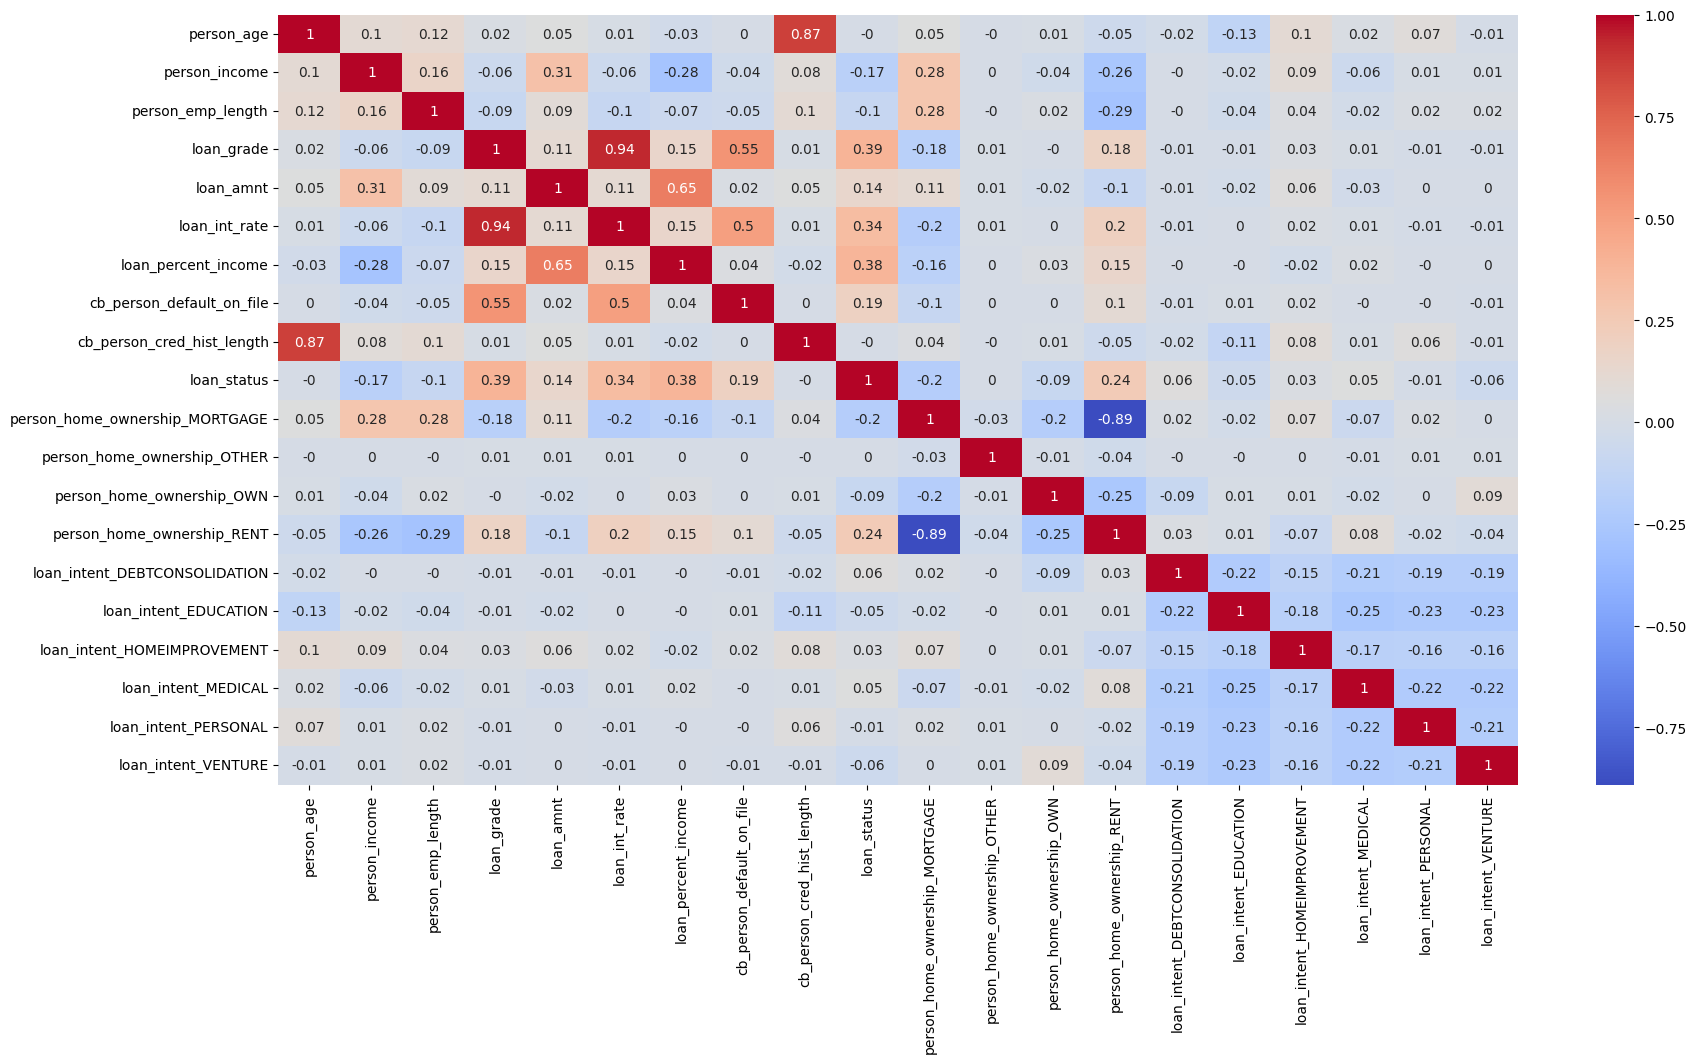

In [39]:
plt.figure(figsize= (20, 10))
sns.heatmap(dfTrain.corr().round(2), annot= True, cmap= 'coolwarm')

In [92]:
dfTrain['bankProfit'] = dfTrain['loan_amnt'] * dfTrain['loan_int_rate']
dfTrain['loan_percent_income'] = np.round((dfTrain['loan_amnt'] / dfTrain['person_income']), 2)
dfTrain['incomeRemain'] = np.round(dfTrain['person_income'] - dfTrain['loan_amnt'])
dfTrain['incomeRemain2'] = np.round(dfTrain['person_income'] - (dfTrain['loan_amnt'] * (1 + dfTrain['loan_int_rate']/100)))
dfTrain['credDage'] = dfTrain['cb_person_cred_hist_length'] / dfTrain['person_age']
dfTrain['empDage'] = dfTrain['person_emp_length'] / dfTrain['person_age']
dfTrain['ageScred'] = dfTrain['person_age'] - dfTrain['cb_person_cred_hist_length']
dfTrain['ageSemp'] = dfTrain['person_age'] - dfTrain['person_emp_length']
dfTrain['empDcred'] = dfTrain['person_emp_length'] / dfTrain['cb_person_cred_hist_length']
dfTrain['empScred'] = dfTrain['person_emp_length'] - dfTrain['cb_person_cred_hist_length']
dfTrain['incomeEmpPast'] = np.round(dfTrain['person_income'] * dfTrain['person_emp_length'])
dfTrain['incomeAnualRaise'] = np.round(dfTrain['person_income'] / dfTrain['person_emp_length'])
dfTrain['creditAppScore'] = np.round(dfTrain['cb_person_cred_hist_length'] * dfTrain['cb_person_default_on_file'])
dfTrain['ageMpercent'] = np.round(dfTrain['person_age'] * dfTrain['loan_percent_income'])

<Axes: >

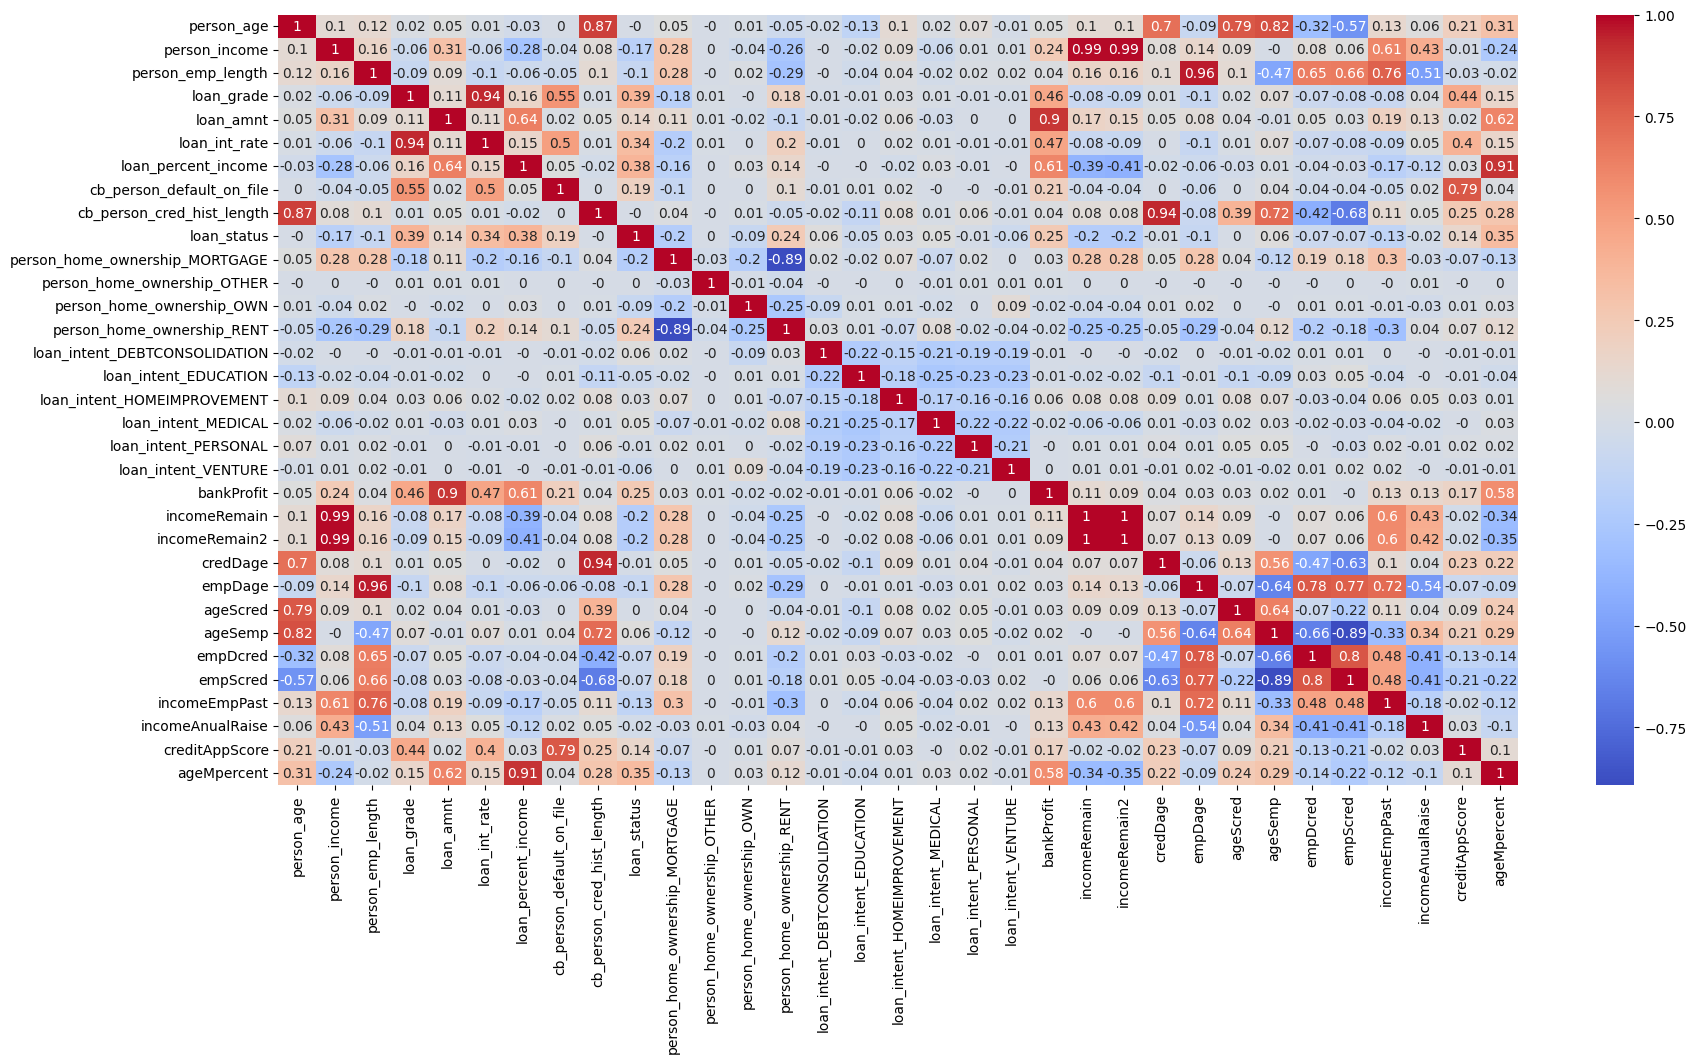

In [93]:
plt.figure(figsize= (20, 10))
sns.heatmap(dfTrain.corr().round(2), annot= True, cmap= 'coolwarm')

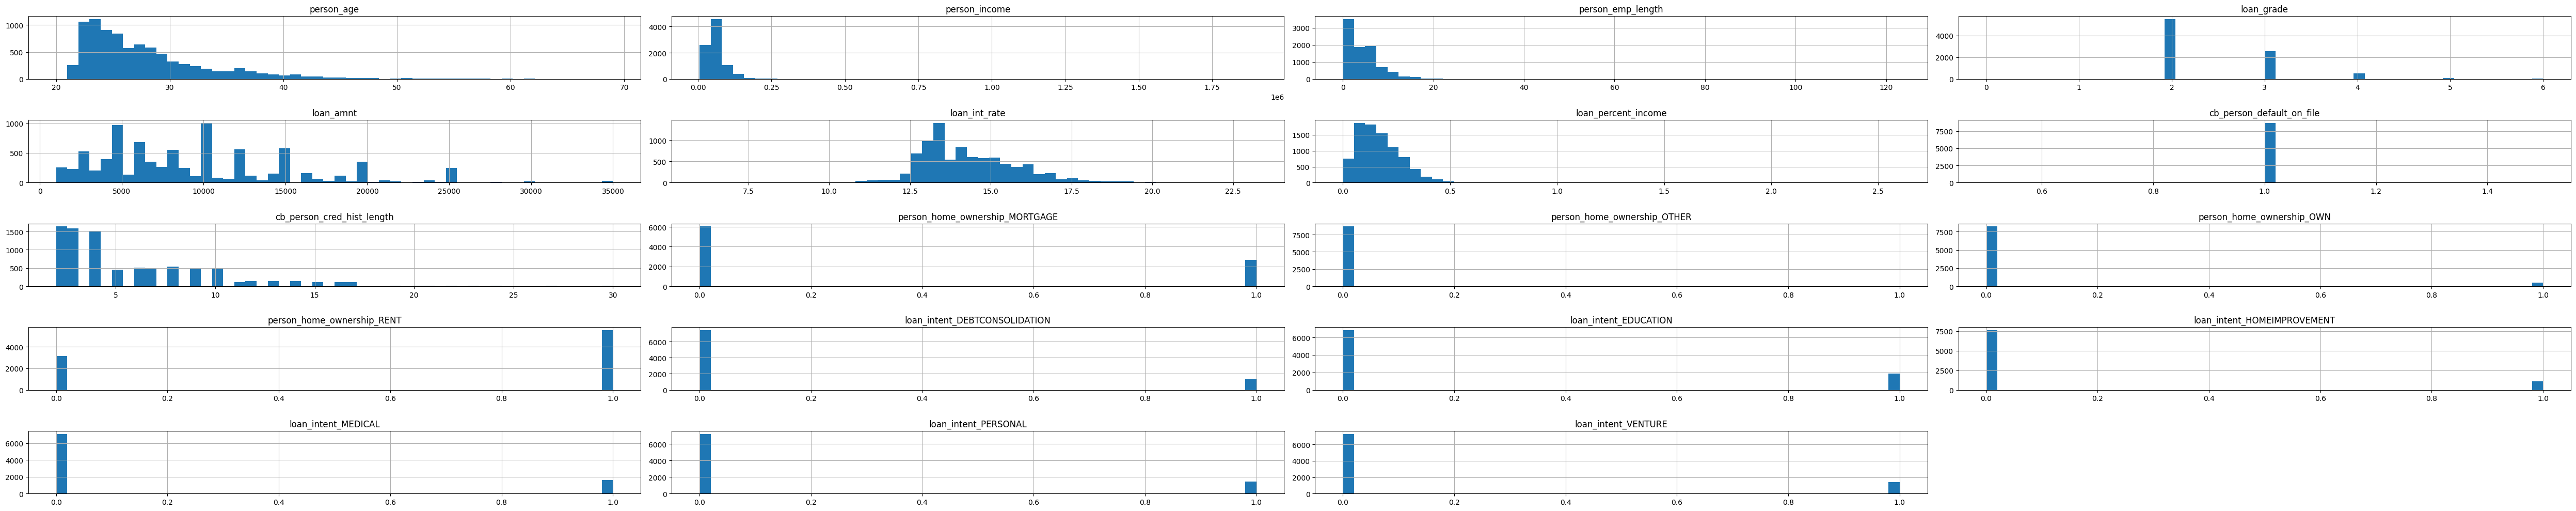

In [76]:
dfTrain.loc[(dfTrain['cb_person_default_on_file']==1)].iloc[:,:20].hist(figsize= (50, 10), bins= 50)
plt.tight_layout()
plt.show()

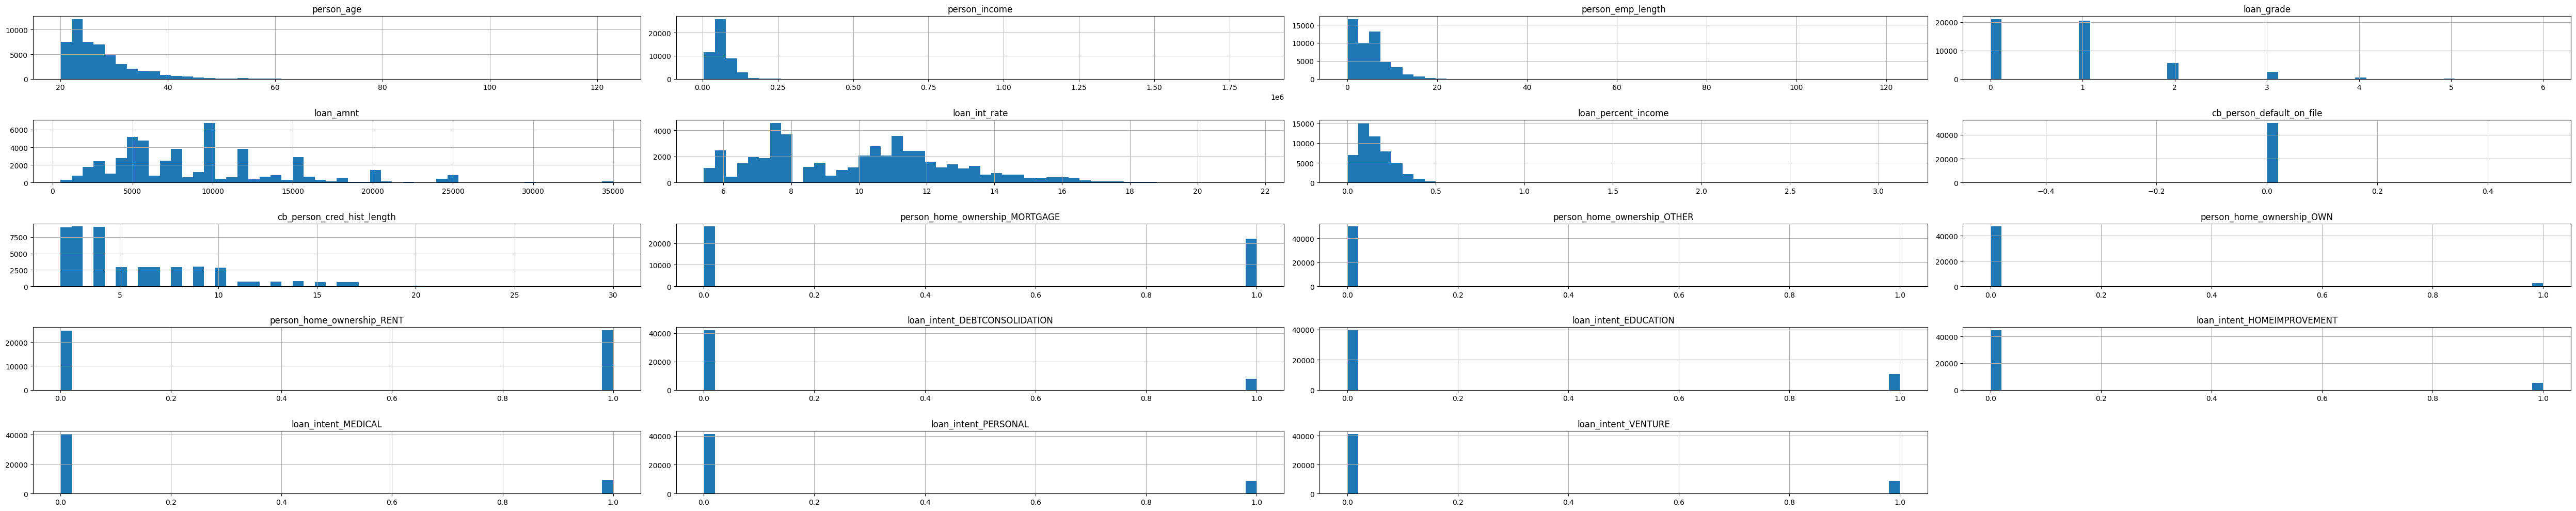

In [77]:
dfTrain.loc[(dfTrain['cb_person_default_on_file']==0)].iloc[:,:20].hist(figsize= (50, 10), bins= 50)
plt.tight_layout()
plt.show()

In [ ]:
sns.histplot(dfTrain.loc[(dfTrain['cb_person_default_on_file']==1)].iloc[:,:20])

In [46]:
dfTrain.loc[dfTrain['person_home_ownership_MORTGAGE']==1, ['person_income', 'person_emp_length']].describe()

,person_income,person_emp_length
count,24824.00,24824.00
mean,76562.61,6.01
std,42233.09,4.27
min,9600.00,0.00
25%,54000.00,3.00
50%,70000.00,6.00
75%,90000.00,8.00
max,1900000.00,123.00


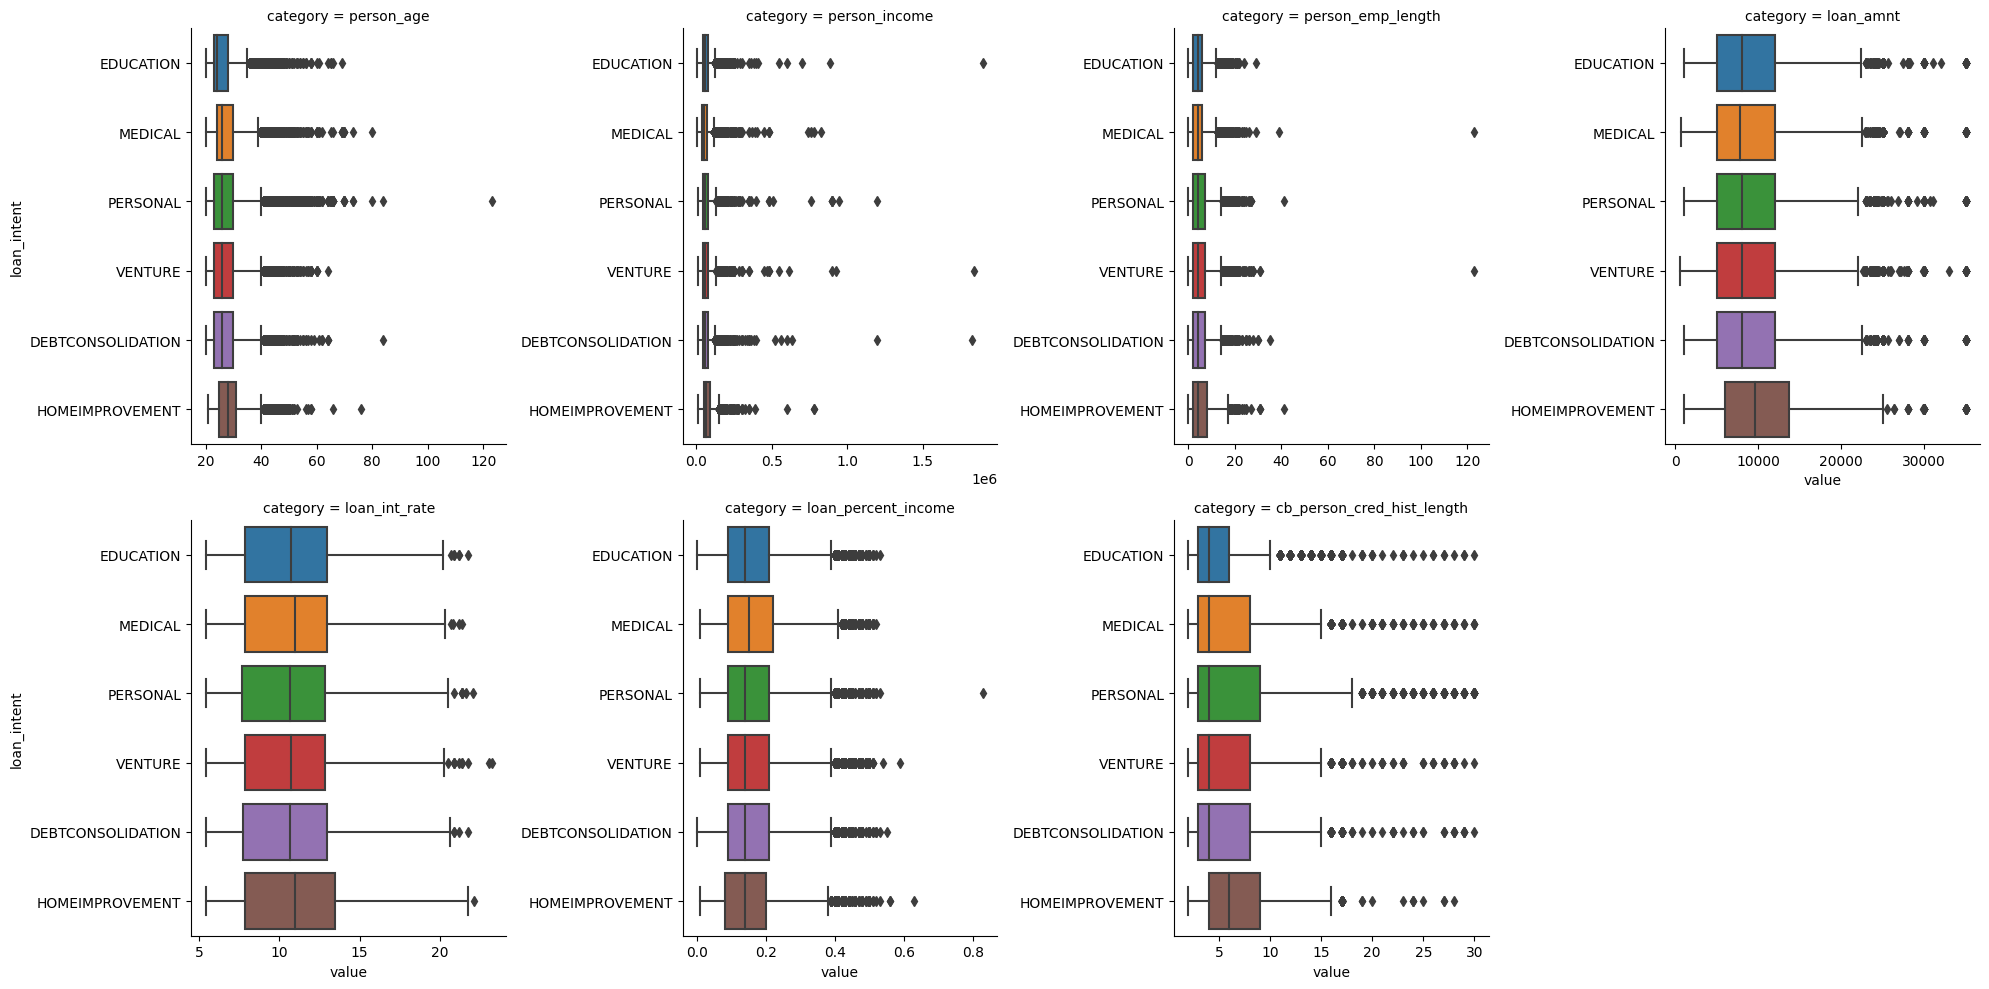

In [89]:
dfx = pd.DataFrame(pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv'))
for col in ['loan_intent']:
    dfMelted = dfx[numFeatures+['loan_grade']+[col]].melt(id_vars= col, var_name= 'category', value_name= 'value')
    sns.catplot(dfMelted, col= 'category', y= col, x= 'value', sharex= False, sharey= False, col_wrap= 4, kind= 'box', height= 5)
    plt.tight_layout()
    plt.show()

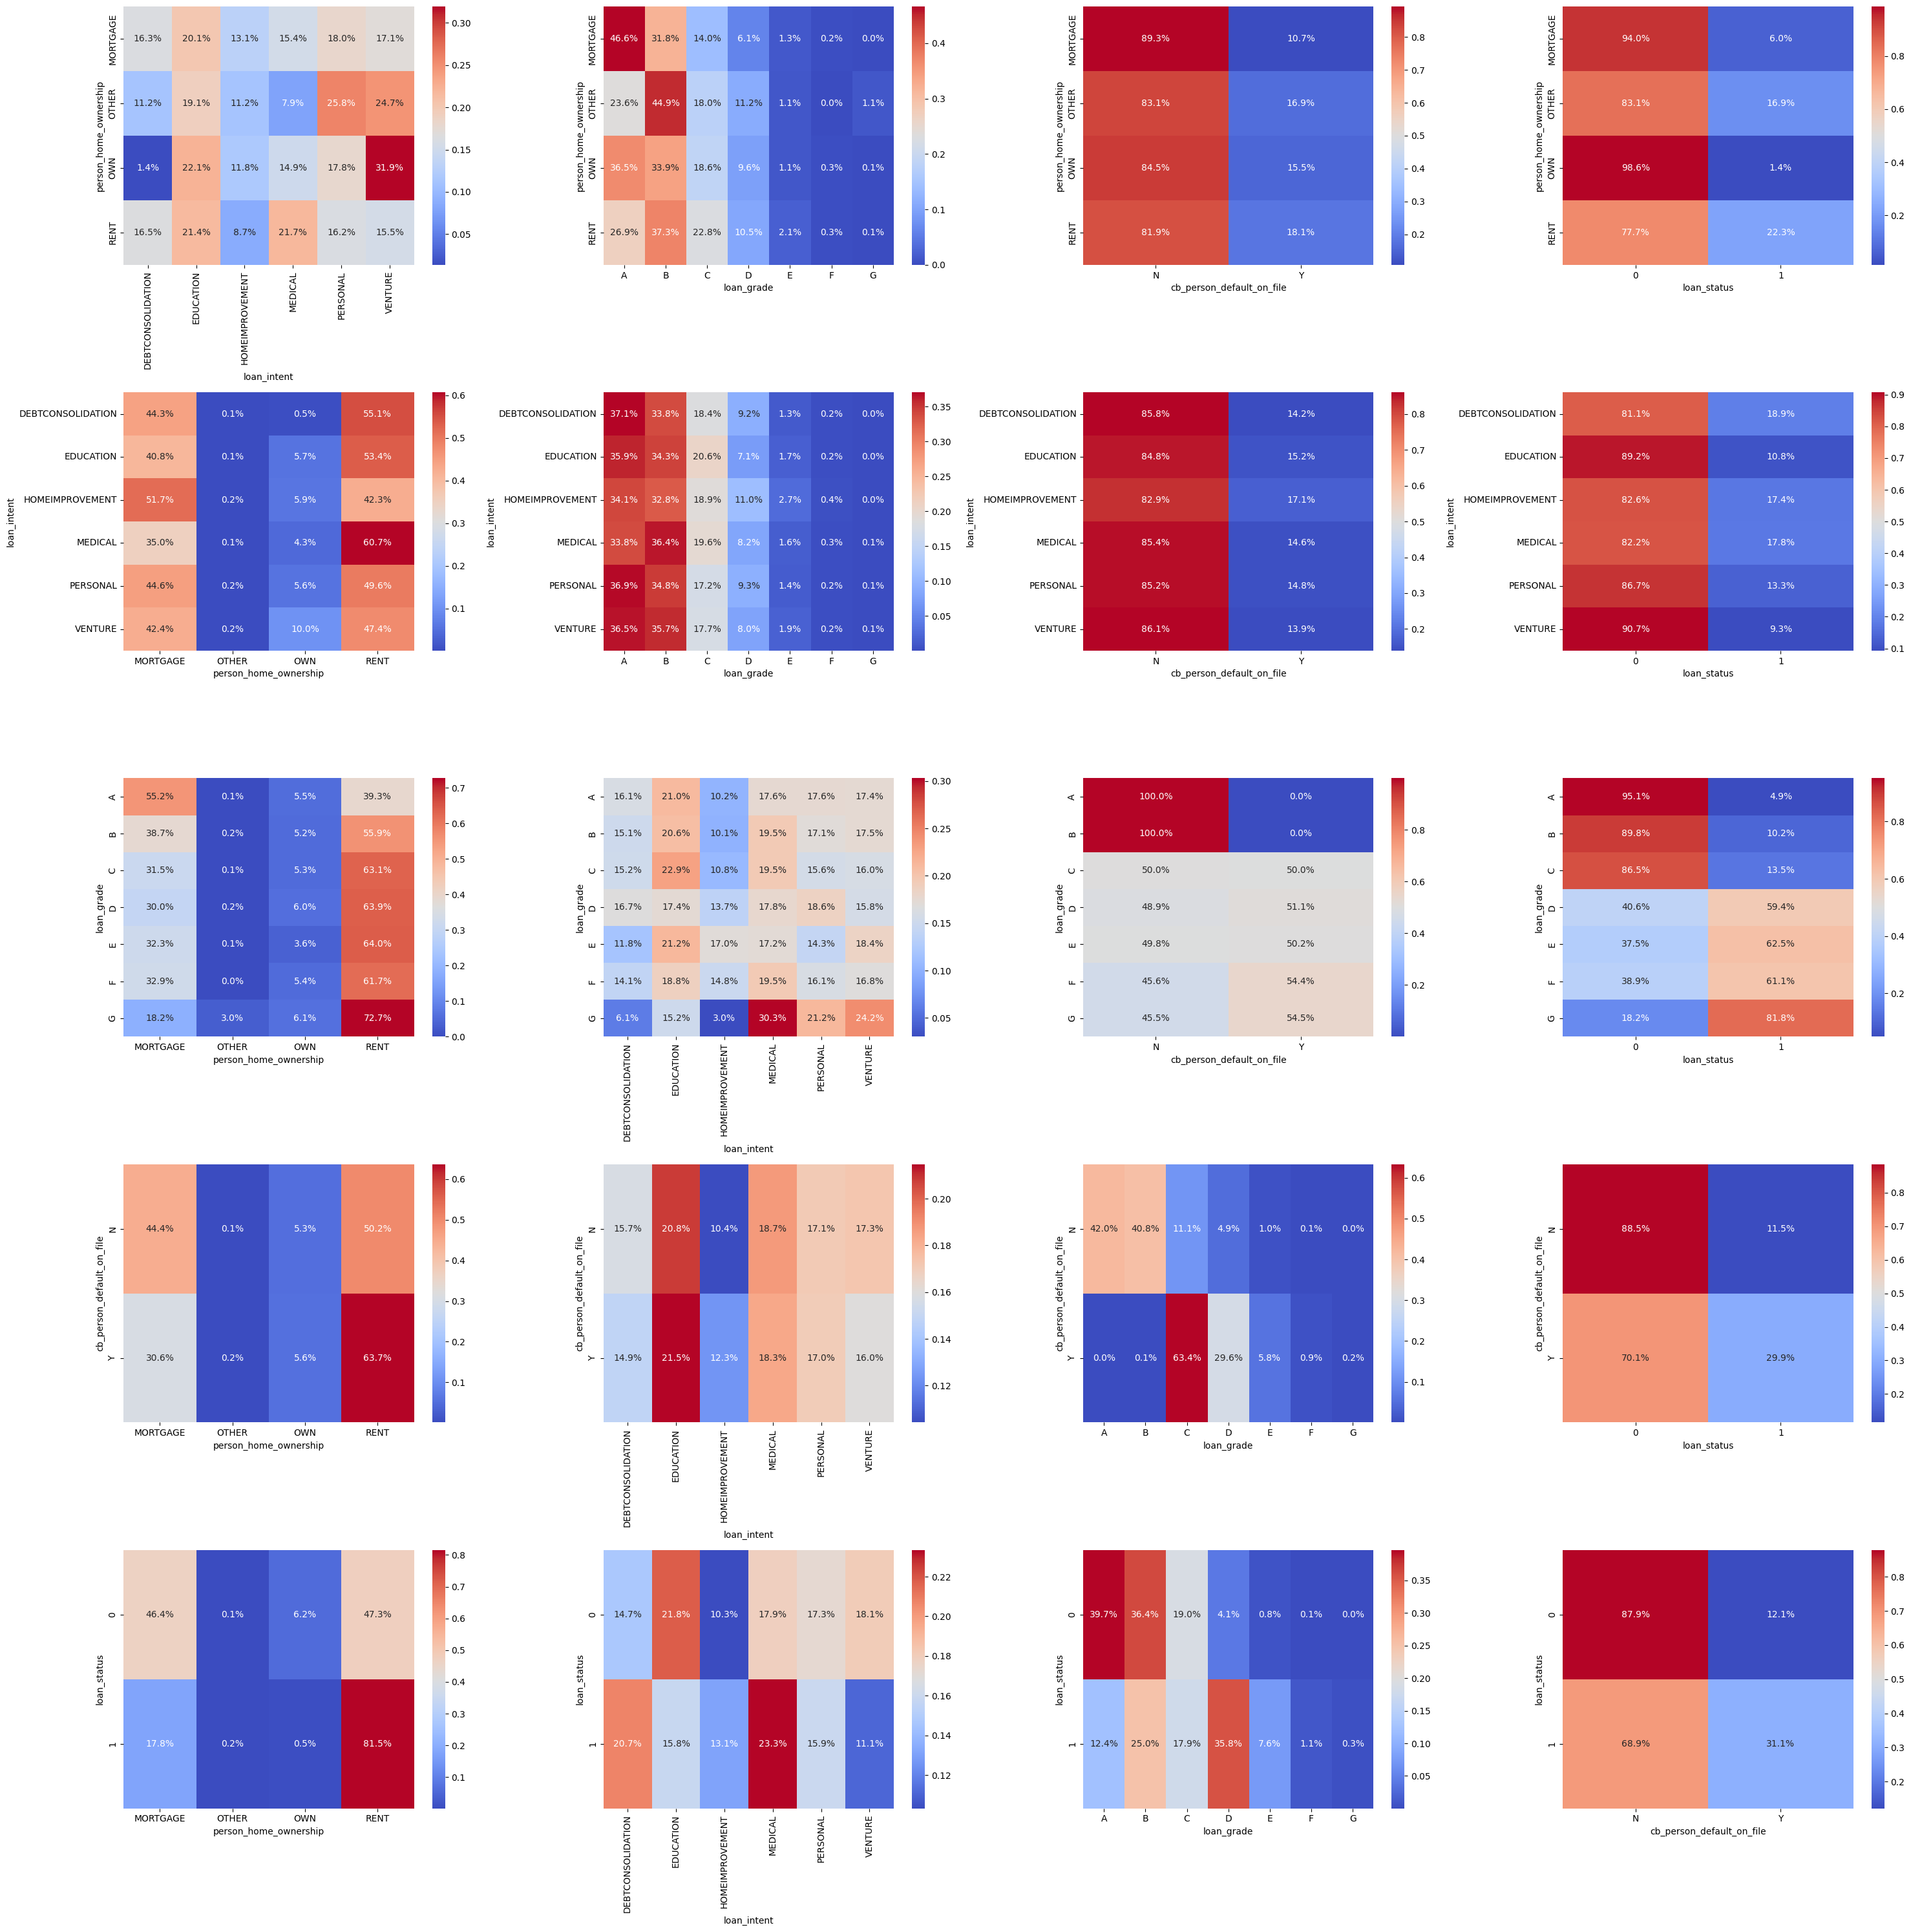

In [91]:
rowNo = 0
colNo = 0
figurse, axes = plt.subplots(len(catFeaturesEDA), len(catFeaturesEDA)-1, figsize= (30, 30))
for col1 in catFeaturesEDA:
    for col2 in [col for col in catFeatures+['loan_status'] if col != col1]:
        contingencyTable = pd.crosstab(dfx[col1], dfx[col2])
        contingencyTable = contingencyTable.div(contingencyTable.sum(axis=1), axis=0)
        sns.heatmap(contingencyTable, cmap= 'coolwarm', annot= True, fmt='.1%', ax= axes[rowNo][colNo])
#         # sns.heatmap(contingency_table, cmap= 'coolwarm', annot= True, fmt='d')
        colNo += 1
    colNo = 0
    rowNo += 1
plt.tight_layout()
plt.show()

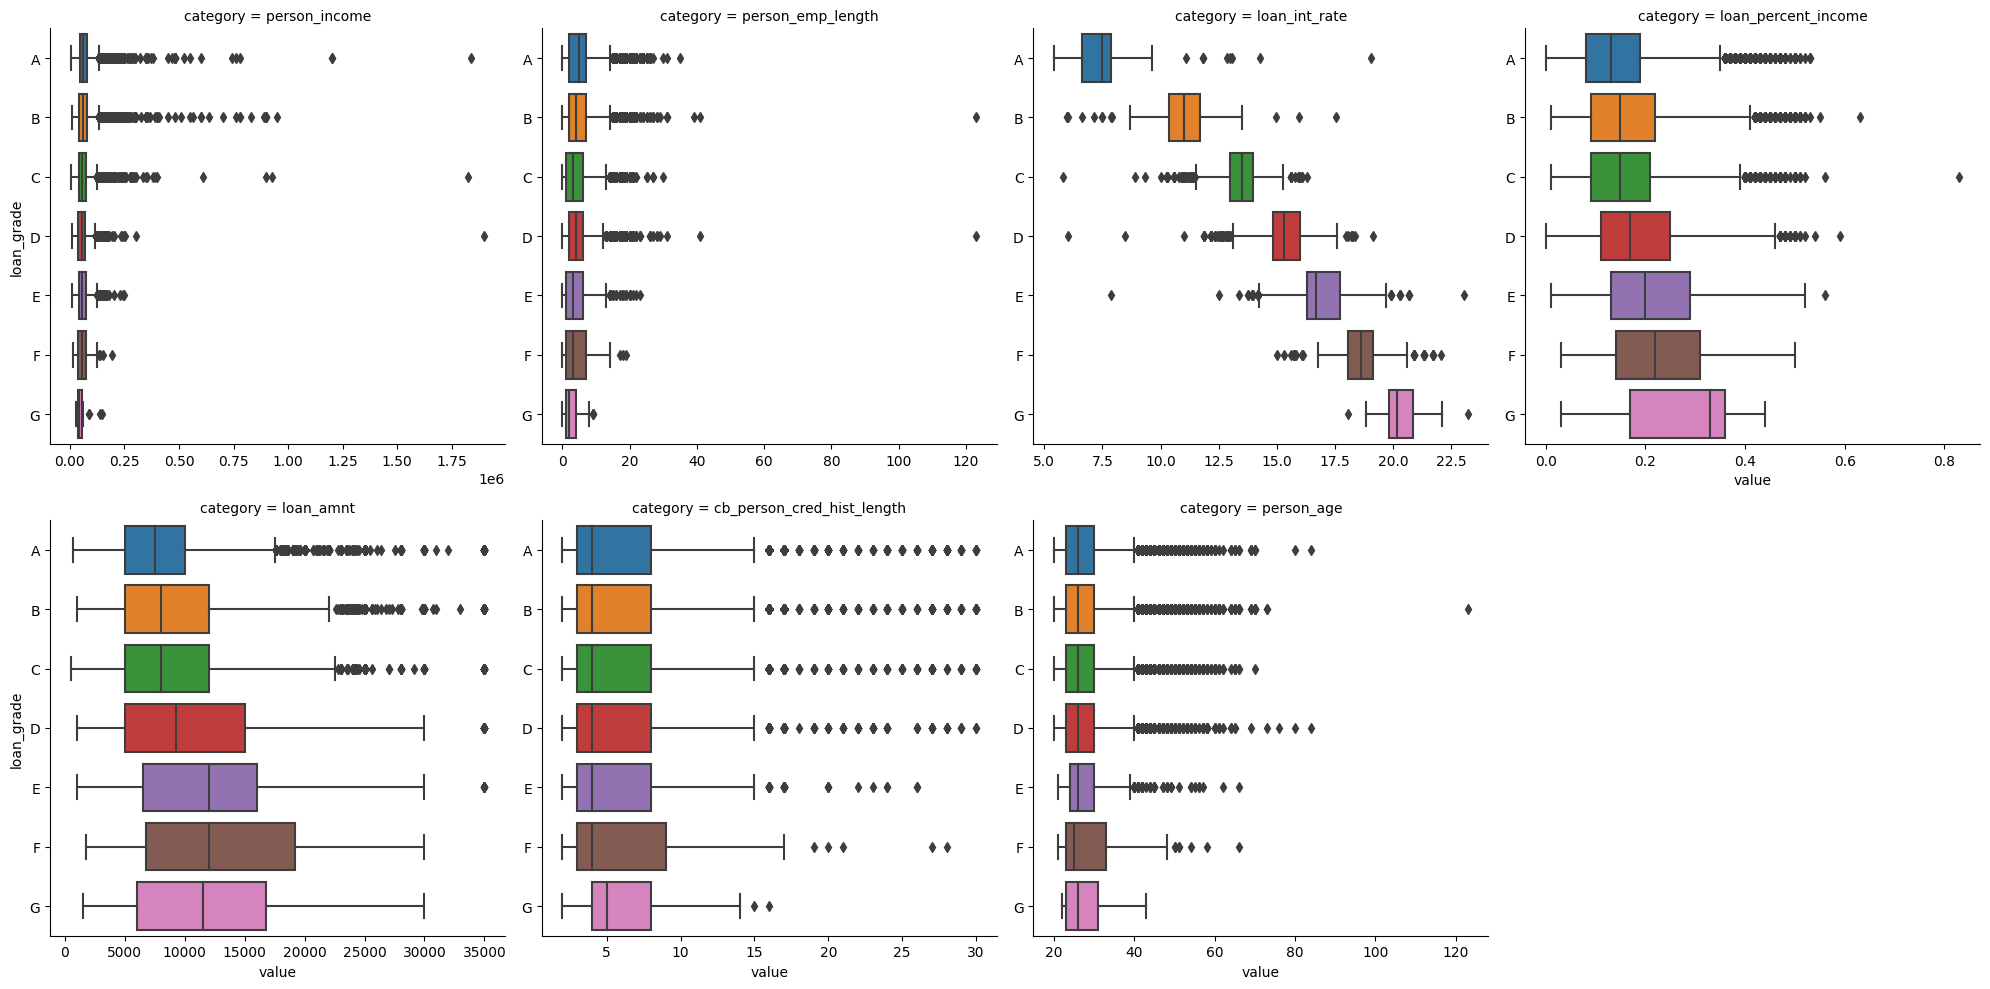

In [13]:
for col in ['loan_grade']:
    dfMelted = dfTrain[numFeatures+[col]].melt(id_vars= col, var_name= 'category', value_name= 'value').sort_values('loan_grade')
    sns.catplot(dfMelted, col= 'category', y= col, x= 'value', sharex= False, sharey= False, col_wrap= 4, kind= 'box', height= 5)
    plt.tight_layout()
    plt.show()

In [ ]:
for col in catFeaturesEDA:
    dfMelted = dfTrain[numFeatures+[col]].melt(id_vars= col, var_name= 'category', value_name= 'value')
    sns.catplot(dfMelted, col= 'category', y= col, x= 'value', sharex= False, sharey= False, col_wrap= 4, kind= 'box', height= 5)
    plt.tight_layout()
    plt.show()

In [ ]:
for col in catFeaturesEDA:
    dfMelted = dfTrain[numFeatures+[col]].melt(id_vars= col, var_name= 'category', value_name= 'value')
    sns.catplot(dfMelted, col= 'category', y= col, x= 'value', sharex= False, sharey= False, col_wrap= 4, kind= 'violin', height= 5)
    plt.tight_layout()
    plt.show()

In [ ]:
for col in catFeaturesEDA:
    dfMelted = dfTrain[numFeatures+[col]].melt(id_vars= col, var_name= 'category', value_name= 'value')
    sns.catplot(dfMelted, col= 'category', y= col, x= 'value', sharex= False, sharey= False, col_wrap= 4, kind= 'point', height= 5)
    plt.tight_layout()
    plt.show()

In [ ]:
for col1 in catFeaturesEDA:
    for col2 in [col for col in catFeaturesEDA if col != col1]:
        sns.catplot(dfTrain[[col1, col2]], col= col1, y= col2, sharex= False, sharey= False, col_wrap= 7, kind= 'count', height= 3)
        plt.tight_layout()
        plt.show()

In [ ]:
for col1 in catFeaturesEDA:
    for col2 in [col for col in catFeaturesEDA if col != col1]:
        sns.catplot(dfTrain[[col1, col2]], y= col1, col= col2, sharex= False, sharey= False, col_wrap= 7, kind= 'strip', height= 3)
        plt.tight_layout()
        plt.show()

In [ ]:
for col in catFeaturesEDA:
    sns.pairplot(dfTrain[numFeatures+[col]], corner= True, hue= col)
    plt.show()

In [ ]:
for df in [dfTrain, dfTest]:
    for col in ['person_age', 'person_emp_length', 'cb_person_cred_hist_length']:
        df[col] = df[col].astype('int16')
    for col in ['loan_amnt']:
        df[col] = df[col].astype('int32')
dfTrain['loan_status'] = dfTrain['loan_status'].astype('int8')

In [ ]:
# Remove outliers in loan_int_rate feature relying to loan_grade feature
for loanGrade in dfTrain['loan_grade'].unique():
    dfx = dfTrain.loc[dfTrain['loan_grade'] == loanGrade, 'loan_int_rate']
    lowerLimit = dfx.quantile(0.01)
    upperLimit = dfx.quantile(0.99)
    dfTrain.loc[(dfTrain['loan_grade'] == loanGrade) & (dfTrain['loan_int_rate'] < lowerLimit), 'loan_int_rate'] = lowerLimit
    dfTrain.loc[(dfTrain['loan_grade'] == loanGrade) & (dfTrain['loan_int_rate'] > upperLimit), 'loan_int_rate'] = upperLimit
    xTest.loc[(xTest['loan_grade'] == loanGrade) & (xTest['loan_int_rate'] < lowerLimit), 'loan_int_rate'] = lowerLimit
    xTest.loc[(xTest['loan_grade'] == loanGrade) & (xTest['loan_int_rate'] > upperLimit), 'loan_int_rate'] = upperLimit

In [ ]:
plt.figure(figsize= (10, 5))
sns.heatmap(dfTrain[numFeatures].corr().round(2), cmap= 'coolwarm', annot= True)

In [ ]:
dfTrain.isna().sum()

In [ ]:
dfTrain[~dfTrain['person_emp_length'].isna()].hist(figsize= (25, 5), bins= 30, layout= (2, 4))
plt.show()
dfTrain[dfTrain['person_emp_length'].isna()].hist(figsize= (25, 5), bins= 30, layout= (2, 4))
plt.show()
dfTrain.loc[dfTrain['loan_int_rate'].isna(), 'person_home_ownership'].value_counts(), dfTrain.loc[~dfTrain['loan_int_rate'].isna(), 'person_home_ownership'].value_counts()

In [ ]:
for df in [dfTrain, xTest]:
    df['person_emp_start_age'] = df['person_age'] - df['person_emp_length']
    df['person_cred_hist_start_age'] = df['person_age'] - df['cb_person_cred_hist_length']

In [ ]:
for col in ['person_home_ownership','loan_intent']:
    oneHotEncoder = OneHotEncoder()
    encodedCol1 = oneHotEncoder.fit_transform(dfTrain[[col]]).toarray()
    dfTrain = pd.concat([dfTrain.drop(col, axis=1), pd.DataFrame(encodedCol1, columns= [f"{col}_{cat}" for cat in oneHotEncoder.categories_[0]])], axis=1)
    encodedCol2 = oneHotEncoder.transform(xTest[[col]]).toarray()
    xTest = pd.concat([xTest.drop(col, axis=1), pd.DataFrame(encodedCol2, columns= [f"{col}_{cat}" for cat in oneHotEncoder.categories_[0]])], axis=1)
for col in ['cb_person_default_on_file']:
    labelEncoder = LabelEncoder()
    dfTrain[col] = labelEncoder.fit_transform(dfTrain[[col]])
    xTest[col] = labelEncoder.transform(xTest[[col]])
for col in ['loan_grade']:
    ordinalEncoder = OrdinalEncoder(categories= [['A', 'B', 'C', 'D', 'E', 'F', 'G']])
    dfTrain[col] = ordinalEncoder.fit_transform(dfTrain[[col]])
    xTest[col] = ordinalEncoder.transform(xTest[[col]])

In [ ]:
idxImpCreditTrain = list(dfTrain[dfTrain['person_cred_hist_start_age']<17].index)
idxImpCreditTest = list(xTest[xTest['person_cred_hist_start_age']<17].index)

idxImpEmpTrain = list(dfTrain[(dfTrain['person_emp_start_age']<15) | (dfTrain['person_emp_length'].isna())].index)
idxImpEmpTest = list(xTest[(xTest['person_emp_start_age']<15) | (dfTrain['person_emp_length'].isna())].index)

idxImpIntTrain = list(dfTrain[dfTrain['loan_int_rate'].isna()].index)
idxImpIntTest = list(xTest[xTest['loan_int_rate'].isna()].index)

idxImpAllTrain = idxImpCreditTrain + idxImpEmpTrain + idxImpIntTrain

In [ ]:
colToImpute = 'cb_person_cred_hist_length'
idxImpTrain = idxImpCreditTrain
idxImpTest = idxImpCreditTest

imputerAutoml = flaml.AutoML()
imputer_settings = {
    "time_budget": 600,
    "metric": 'rmse',
    "task": 'regression',
    "log_file_name": 'mylog.log',
    "early_stop": True, 
    "seed": 42,
}

imputerAutoml.fit(X_train = dfTrain.loc[~dfTrain.index.isin(idxImpAllTrain)].drop(['loan_status', colToImpute], axis= 1), y_train = dfTrain.loc[~dfTrain.index.isin(idxImpAllTrain), colToImpute], **imputer_settings)
dfTrain.loc[dfTrain.index.isin(idxImpTrain), colToImpute] = np.round(imputerAutoml.predict(dfTrain.loc[dfTrain.index.isin(idxImpTrain)].drop(['loan_status', colToImpute], axis= 1)))
xTest.loc[xTest.index.isin(idxImpTest), colToImpute] = np.round(imputerAutoml.predict(xTest.loc[xTest.index.isin(idxImpTest)].drop(colToImpute, axis= 1)))

In [ ]:
colToImpute = 'person_emp_length'
idxImpTrain = idxImpEmpTrain
idxImpTest = idxImpEmpTest

imputerAutoml = flaml.AutoML()
imputer_settings = {
    "time_budget": 600,
    "metric": 'rmse',
    "task": 'regression',
    "log_file_name": 'mylog.log',
    "early_stop": True, 
    "seed": 42,
}

imputerAutoml.fit(X_train = dfTrain.loc[~dfTrain.index.isin(idxImpAllTrain)].drop(['loan_status', colToImpute], axis= 1), y_train = dfTrain.loc[~dfTrain.index.isin(idxImpAllTrain), colToImpute], **imputer_settings)
dfTrain.loc[dfTrain.index.isin(idxImpTrain), colToImpute] = np.round(imputerAutoml.predict(dfTrain.loc[dfTrain.index.isin(idxImpTrain)].drop(['loan_status', colToImpute], axis= 1)))
xTest.loc[xTest.index.isin(idxImpTest), colToImpute] = np.round(imputerAutoml.predict(xTest.loc[xTest.index.isin(idxImpTest)].drop(colToImpute, axis= 1)))

In [ ]:
colToImpute = 'loan_int_rate'
idxImpTrain = idxImpIntTrain
idxImpTest = idxImpIntTest

imputerAutoml = flaml.AutoML()
imputer_settings = {
    "time_budget": 600,
    "metric": 'rmse',
    "task": 'regression',
    "log_file_name": 'mylog.log',
    "early_stop": True, 
    "seed": 42,
}

imputerAutoml.fit(X_train = dfTrain.loc[~dfTrain.index.isin(idxImpAllTrain)].drop(['loan_status', colToImpute], axis= 1), y_train = dfTrain.loc[~dfTrain.index.isin(idxImpAllTrain), colToImpute], **imputer_settings)
dfTrain.loc[dfTrain.index.isin(idxImpTrain), colToImpute] = np.round(imputerAutoml.predict(dfTrain.loc[dfTrain.index.isin(idxImpTrain)].drop(['loan_status', colToImpute], axis= 1)))
if xTest[colToImpute].isna().sum():
    xTest.loc[xTest.index.isin(idxImpTest), colToImpute] = np.round(imputerAutoml.predict(xTest.loc[xTest.index.isin(idxImpTest)].drop(colToImpute, axis= 1)))

In [ ]:
dfx = pd.concat([pd.DataFrame(pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')), pd.DataFrame(pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv'))], axis= 0).reset_index(drop= True)
dfx['person_emp_start_age'] = dfx['person_age'] - dfx['person_emp_length']
dfx['person_cred_hist_start_age'] = dfx['person_age'] - dfx['cb_person_cred_hist_length']
dfx['loan_status'] = dfx['loan_status'].astype('str')

In [ ]:
dfx['empDcred'] = dfx['person_emp_length'] / dfx['cb_person_cred_hist_length']
dfx['empScred'] = dfx['person_emp_length'] - dfx['cb_person_cred_hist_length']
dfx['bankProfit'] = dfx['loan_amnt'] * dfx['loan_int_rate']
dfx['loan_percent_income'] = np.round((dfx['loan_amnt'] / dfx['person_income']), 2)
dfx['incomeRemain'] = np.round(dfx['person_income'] - dfx['loan_amnt'])
dfx['incomeRemain2'] = np.round(dfx['person_income'] - (dfx['loan_amnt'] * (1 + dfx['loan_int_rate']/100)))

In [ ]:
for col in ['loan_status']:
    dfMelted = dfx.loc[~dfx.index.isin(idxImpAllTrain), numFeatures+[col]].melt(id_vars= col, var_name= 'category', value_name= 'value')
    sns.catplot(dfMelted, col= 'category', y= col, x= 'value', sharex= False, sharey= False, col_wrap= 5, kind= 'box', height= 4)
    plt.tight_layout()
    plt.show()

In [ ]:
numFeatures = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_emp_start_age', 'person_cred_hist_start_age', 'incomeRemain', 'incomeRemain2', 'loan_status']
plt.figure(figsize= (20,5))
sns.heatmap(dfx[numFeatures].corr().round(2), cmap= 'coolwarm', annot= True)

In [ ]:
numFeatures = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_emp_start_age', 'person_cred_hist_start_age', 'incomeRemain', 'incomeRemain2']
for col in ['loan_status']:
    dfMelted = dfx[numFeatures+[col]].melt(id_vars= col, var_name= 'category', value_name= 'value')
    sns.catplot(dfMelted, col= 'category', y= col, x= 'value', sharex= False, sharey= False, col_wrap= 5, kind= 'box', height= 4)
    plt.tight_layout()
    plt.show()

In [ ]:
rowNo = 0
colNo = 0
figurse, axes = plt.subplots(len(catFeaturesEDA), len(catFeaturesEDA)-1, figsize= (30, 30))
for col1 in catFeaturesEDA:
    for col2 in [col for col in catFeatures+['loan_status'] if col != col1]:
        contingencyTable = pd.crosstab(dfx[col1], dfx[col2])
        contingencyTable = contingencyTable.div(contingencyTable.sum(axis=1), axis=0)
        sns.heatmap(contingencyTable, cmap= 'coolwarm', annot= True, fmt='.1%', ax= axes[rowNo][colNo])
#         # sns.heatmap(contingency_table, cmap= 'coolwarm', annot= True, fmt='d')
        colNo += 1
    colNo = 0
    rowNo += 1
plt.tight_layout()
plt.show()

In [ ]:
dfx['incomeRemain'] = np.round(dfx['person_income'] - dfx['loan_amnt'])
dfx['incomeRemain2'] = np.round(dfx['person_income'] - (dfx['loan_amnt'] * (1 + dfx['loan_int_rate']/100)))
dfx.head(1)

In [ ]:
dfx['person_income'].describe()

In [ ]:
dfx['loan_percent_incomeNew'] = np.round((dfx['loan_amnt'] / dfx['person_income']), 2)
dfx['loan_percent_incomeDiff'] = np.abs(dfx['loan_percent_incomeNew'] - dfx['loan_percent_income'])
dfx[dfx['loan_percent_incomeDiff']>0.005]

In [ ]:
dfx.loc[dfx['loan_percent_income']<0.01]

In [ ]:
dfx.loc[dfx['person_income']>1000000]
# plt.show()

In [ ]:
sns.jointplot(dfx, y= 'person_age', x= 'incomeRemain2', hue= 'loan_status', height= 5)

In [ ]:
sns.jointplot(dfx[dfx['loan_grade']=='A'].drop('id', axis= 1), y= 'loan_amnt', x= 'person_income', hue= 'loan_status', height= 5)

In [ ]:
sns.jointplot(dfx[(dfx['loan_grade']=='A')].drop('id', axis= 1), x= 'loan_amnt', y= 'loan_percent_income', hue= 'loan_status', height= 5)

In [ ]:
sns.jointplot(dfx[(dfx['loan_grade']=='A') & (dfx['loan_percent_income']<0.3)].drop('id', axis= 1), x= 'loan_amnt', y= 'loan_percent_income', hue= 'loan_status', height= 5)

In [ ]:
sns.pairplot(dfx[(dfx['loan_grade']=='A') & (dfx['loan_status']=='0')].drop('id', axis= 1), corner= True)

In [ ]:
dff= dfx.loc[(dfx['loan_grade']=='A'), 'loan_int_rate']
dff.describe()

In [ ]:
dfx[(dfx['loan_grade']=='A') & (dfx['loan_int_rate']>10)]

In [ ]:
dfMelted = dfx[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_emp_start_age', 'person_cred_hist_start_age', 'incomeRemain', 
                 'incomeRemain2', 'loan_intent']].melt(id_vars= col, var_name= 'category', value_name= 'value')
sns.catplot(dfMelted, col= 'category', y= col, x= 'value', sharex= False, sharey= False, col_wrap= 4, kind= 'violin', height= 5)
plt.tight_layout()
plt.show()

In [ ]:
# replace anomalies in person_emp_length & cb_person_cred_hist_length
for df in [dfTrain, xTest]:
    df['person_emp_start_age'] = df['person_age'] - df['person_emp_length']
    df.loc[df['person_emp_start_age']<15, 'person_emp_length'] = df.loc[df['person_emp_start_age']<15, 'person_age'] - dfTrain['person_emp_start_age'].mode()[0]
    df['person_cred_hist_start_age'] = df['person_age'] - df['cb_person_cred_hist_length']
#     df.loc[df['person_cred_hist_start_age'] == 17, 'cb_person_cred_hist_length'] = df.loc[df['person_emp_start_age'] == 17, 'person_age'] - 18

MaskTrain = dfTrain['person_cred_hist_start_age']>=17
MaskMissingTrain = dfTrain['person_cred_hist_start_age']<17
MaskMissingTest = xTest['person_cred_hist_start_age']<17

linearRegression = LinearRegression()
linearRegression.fit(dfTrain.loc[MaskTrain,['person_age']], dfTrain.loc[MaskTrain, 'cb_person_cred_hist_length'])
dfTrain.loc[MaskMissingTrain, 'cb_person_cred_hist_length'] = np.round(linearRegression.predict(dfTrain.loc[MaskMissingTrain, ['person_age']]))
xTest.loc[MaskMissingTest, 'cb_person_cred_hist_length'] = np.round(linearRegression.predict(xTest.loc[MaskMissingTest, ['person_age']]))

for df in [dfTrain, xTest]:
    df.drop(['person_emp_start_age', 'person_cred_hist_start_age'], axis= 1, inplace= True)

In [ ]:
for df in [dfTrain, xTest]:
    df['person_income_A_loan_int_rate'] = df['person_income'] + df['loan_int_rate'] # is an option to be removed
    df['person_income_D_loan_int_rate'] = df['person_income'] / df['loan_int_rate']
    df['loan_int_rate_M_loan_percent_income'] = df['loan_int_rate'] * df['loan_percent_income'] # loan_percent_income should be removed
    df['loan_percent_income'] = df['loan_amnt'] / df['person_income']
    df['loan_amount_plus_interest'] = df['loan_amnt'] * (1 + df['loan_int_rate'])
    df['loan_percent_plus_interest_income'] = df['loan_amount_plus_interest'] / df['person_income']

In [ ]:
probs = stats.boxcox_normplot(dfTrain['person_income'], -20, 20)
best = pd.DataFrame(probs).transpose().sort_values(1, ascending= False).iloc[0,0]
dfTrain['person_income'] = stats.boxcox(dfTrain['person_income'], best)
xTest['person_income'] = stats.boxcox(xTest['person_income'], best)

In [ ]:
for col in ['person_age', 'person_emp_length', 'cb_person_cred_hist_length']:
    #     minMaxScaler = MinMaxScaler()
    #     dfTrain[col] = minMaxScaler.fit_transform(dfTrain[col])
    #     xTest[col] = minMaxScaler.transform(xTest[col])
        robustScaler = RobustScaler()
        dfTrain[col] = robustScaler.fit_transform(dfTrain[[col]])
        xTest[col] = robustScaler.transform(xTest[[col]])
for col in ['person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']:
        standardScaler = StandardScaler()
        dfTrain[col] = standardScaler.fit_transform(dfTrain[[col]])
        xTest[col] = standardScaler.transform(xTest[[col]])

In [ ]:
for df in [dfTrain, xTest]:
    df.drop(['person_home_ownership_OTHER'], axis= 1, inplace= True)

In [ ]:
xTrain = dfTrain.copy()
yTrain = xTrain.pop('loan_status')

In [ ]:
xTrain, yTrain = SMOTE(random_state=42).fit_resample(xTrain, yTrain)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xTrain, yTrain)
lazyClassifier = LazyClassifier(verbose=1)#verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = lazyClassifier.fit(X_train, X_test, y_train, y_test)
print(models)

In [ ]:
automl = flaml.AutoML()
automl_settings = {
    "time_budget": 7200,
    "metric": 'roc_auc',
    "task": 'classification',
    "log_file_name": 'mylog.log',
    "early_stop": True, 
    "seed": 42,
#     "ensemble": True,
#     'estimator_list': ['lgbm'],
}
automl.fit(X_train = xTrain, y_train = yTrain, **automl_settings)

In [ ]:
bestModel = automl.model.estimator
with open('Automl36.pkl', 'wb') as f:
    pickle.dump(bestModel, f)
bestModel

In [ ]:
subPred = bestModel.predict_proba(xTest)[:,1]
subId['loan_status'] = subPred
subId.to_csv('Automl37.csv', index= False)

In [ ]:
dfFeatureImp = pd.DataFrame({'Importance':automl.model.feature_importances_}, index= automl.model.feature_names_in_)/pd.DataFrame({'Importance':automl.model.feature_importances_}, index= automl.model.feature_names_in_).sum()
dfFeatureImp.sort_values('Importance').plot(kind= 'barh', figsize= (20, 10))

In [ ]:
confusionMatrix = confusion_matrix(yTrain, bestModel.predict(xTrain), normalize= 'true')
sns.heatmap(confusionMatrix, cmap= 'coolwarm', annot= True)

In [ ]:
permutationImportance = permutation_importance(bestModel, xTrain, yTrain)
dfPerImp = pd.DataFrame(permutationImportance.values(), index= permutationImportance.keys(), columns= xTrain.columns).transpose()['importances_mean']
dfPerImp.sort_values().plot(kind= 'barh', figsize= (20, 10))

In [ ]:
mi = mutual_info_classif(xTrain, yTrain)
a = pd.DataFrame(mi, columns= ['mic'],index = xTrain.columns).sort_values('mic')
a.plot(kind= 'barh')

In [ ]:
plt.figure(figsize= (20, 10))
sns.heatmap(pd.concat([xTrain, yTrain], axis= 1).corr().round(2), cmap= 'coolwarm', annot= True)
plt.show()